In [1]:
# Import all required libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
data = pd.read_csv("TBO_4k_train.csv", encoding="latin1")

In [3]:
# Display first few rows
print("First 5 rows:")
data.head()

First 5 rows:


,id,text,T1 Target,T1 Argument,T1 Harmful,T2 Target,T2 Argument,T2 Harmful,T3 Target,T3 Argument,...,T4 Harmful,T5 Target,T5 Argument,T5 Harmful,T6 Target,T6 Argument,T6 Harmful,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,1158315949990252544,@USER Love it keep up the good work sunshine b...,@USER,fuck em all,NO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1161787110359273472,Lmaooo yâall got other women telling yâall...,y'all,sounds stupid,YES,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1161808970727743488,@USER I feel that sis. They needa begin deacti...,niggas,niggas,YES,niggas,deactivating,YES,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1186683819274801152,"all ""rivalry's"" and shit talking aside im so h...",NaN,shit talking,NO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1187391554757038081,Black musicians think they have to say a bunch...,Black musicians,homo shit,YES,Black musicians,sad,YES,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Shape of the dataset
print("\nShape of dataset (rows, columns):")
print(data.shape)


Shape of dataset (rows, columns):
(4909, 23)


In [5]:
# Column names
print("\nColumns in dataset:")
print(data.columns)


Columns in dataset:
Index(['id', 'text', 'T1 Target', 'T1 Argument', 'T1 Harmful', 'T2 Target',
       'T2 Argument', 'T2 Harmful', 'T3 Target', 'T3 Argument', 'T3 Harmful',
       'T4 Target', 'T4 Argument', 'T4 Harmful', 'T5 Target', 'T5 Argument',
       'T5 Harmful', 'T6 Target', 'T6 Argument', 'T6 Harmful', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')


In [6]:
# Basic info about data types and non-null counts
print("\nDataset info:")
data.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           4002 non-null   object 
 1   text         4001 non-null   object 
 2   T1 Target    2934 non-null   object 
 3   T1 Argument  3958 non-null   object 
 4   T1 Harmful   3999 non-null   object 
 5   T2 Target    1631 non-null   object 
 6   T2 Argument  2072 non-null   object 
 7   T2 Harmful   2073 non-null   object 
 8   T3 Target    532 non-null    object 
 9   T3 Argument  669 non-null    object 
 10  T3 Harmful   669 non-null    object 
 11  T4 Target    121 non-null    object 
 12  T4 Argument  151 non-null    object 
 13  T4 Harmful   151 non-null    object 
 14  T5 Target    23 non-null     object 
 15  T5 Argument  29 non-null     object 
 16  T5 Harmful   29 non-null     object 
 17  T6 Target    2 non-null      object 
 18  T6 Argument  2 non-null      obje

In [7]:
# Count of missing values per column
print("\nMissing values per column:")
data.isnull().sum()


Missing values per column:


,0
id,907
text,908
T1 Target,1975
T1 Argument,951
T1 Harmful,910
T2 Target,3278
T2 Argument,2837
T2 Harmful,2836
T3 Target,4377
T3 Argument,4240


* Data processing – drop unused columns, create target, handle missing values

In [8]:
# Remove unnamed columns that do not carry information
data = data.loc[:, ~data.columns.str.contains("^Unnamed")]

print("\nColumns after removing unnamed ones:")
print(data.columns)


Columns after removing unnamed ones:
Index(['id', 'text', 'T1 Target', 'T1 Argument', 'T1 Harmful', 'T2 Target',
       'T2 Argument', 'T2 Harmful', 'T3 Target', 'T3 Argument', 'T3 Harmful',
       'T4 Target', 'T4 Argument', 'T4 Harmful', 'T5 Target', 'T5 Argument',
       'T5 Harmful', 'T6 Target', 'T6 Argument', 'T6 Harmful'],
      dtype='object')


In [9]:
# Ensure text column exists and handle missing text
data["text"] = data["text"].astype(str)
data["text"] = data["text"].replace("nan", "")
data["text_length"] = data["text"].str.len()
data = data[data["text_length"] > 0]

print("\nShape after removing empty texts:")
data.shape


Shape after removing empty texts:


(4001, 21)

In [10]:
# Create binary offensive label using harmful annotation columns
harmful_columns = ["T1 Harmful", "T2 Harmful", "T3 Harmful", "T4 Harmful", "T5 Harmful", "T6 Harmful"]

In [11]:
# Keep only existing harmful columns
existing_harmful_columns = []
existing_harmful_columns = harmful_columns
existing_harmful_columns = [col for col in existing_harmful_columns if col in data.columns]

In [12]:
# Standardise values in harmful columns and convert to numeric indicators
harmful_frame = data[existing_harmful_columns]
harmful_frame = harmful_frame.fillna("NO")
harmful_frame = harmful_frame.replace("yes", "YES")
harmful_frame = harmful_frame.replace("Yes", "YES")
harmful_frame = harmful_frame.replace("No", "NO")
harmful_frame = harmful_frame.replace({"YES": 1, "NO": 0})

In [13]:
# Aggregate harmful indicator across all targets
data["label_offensive"] = harmful_frame.max(axis=1)
data["label_offensive"] = data["label_offensive"].fillna(0)
data["label_offensive"] = data["label_offensive"].astype(int)

print("\nLabel distribution (0 = not offensive, 1 = offensive):")
print(data["label_offensive"].value_counts())


Label distribution (0 = not offensive, 1 = offensive):
label_offensive
1    2889
0    1112
Name: count, dtype: int64


In [53]:
# Keep only useful columns for modelling and analysis
target_columns = ["text", "label_offensive"]
data_model = data[target_columns]

print("\nData for modelling (preview):")
data_model.head()


Data for modelling (preview):


,text,label_offensive
0,@USER Love it keep up the good work sunshine b...,0
1,Lmaooo yâall got other women telling yâall...,1
2,@USER I feel that sis. They needa begin deacti...,1
3,"all ""rivalry's"" and shit talking aside im so h...",0
4,Black musicians think they have to say a bunch...,1


* Exploratory Data Analysis (EDA)

In [54]:
sns.set(style="whitegrid")

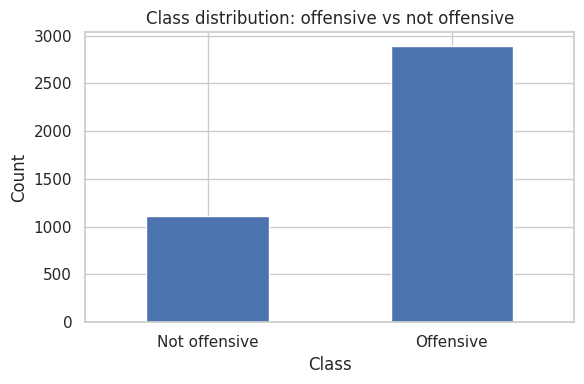

In [55]:
# Graph 1: Class distribution
plt.figure(figsize=(6, 4))
data_model["label_offensive"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0, 1], ["Not offensive", "Offensive"], rotation=0)
plt.title("Class distribution: offensive vs not offensive")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

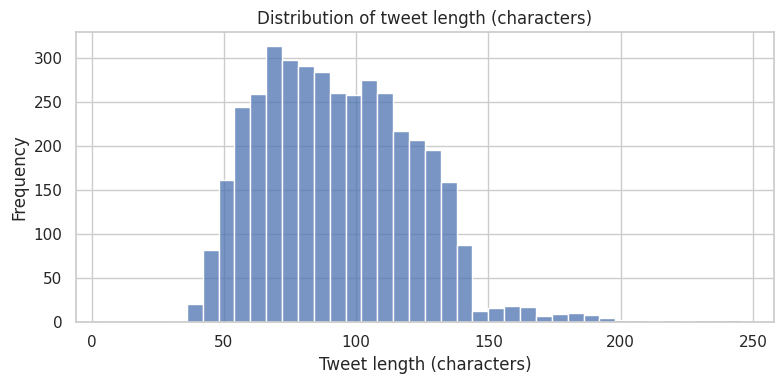

In [56]:
# Graph 2: Distribution of tweet lengths
plt.figure(figsize=(8, 4))
sns.histplot(data["text_length"], bins=40, kde=False)
plt.title("Distribution of tweet length (characters)")
plt.xlabel("Tweet length (characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

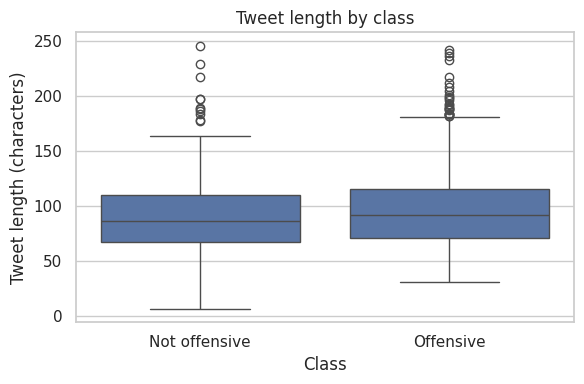

In [57]:
# Graph 3: Tweet length by class
plt.figure(figsize=(6, 4))
sns.boxplot(x=data["label_offensive"], y=data["text_length"])
plt.xticks([0, 1], ["Not offensive", "Offensive"])
plt.title("Tweet length by class")
plt.xlabel("Class")
plt.ylabel("Tweet length (characters)")
plt.tight_layout()
plt.show()

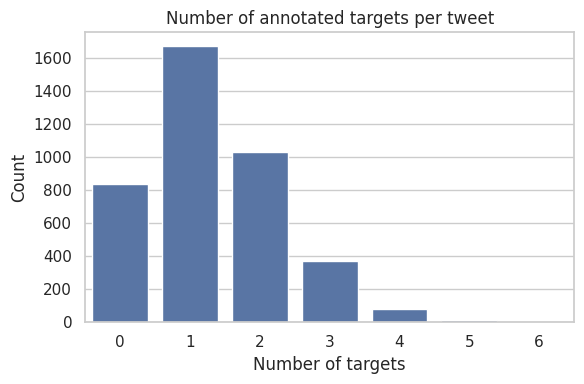

In [58]:
# Graph 4: Number of annotated targets per tweet
target_columns_full = ["T1 Target", "T2 Target", "T3 Target", "T4 Target", "T5 Target", "T6 Target"]
target_columns_existing = [col for col in target_columns_full if col in data.columns]
data["num_targets"] = data[target_columns_existing].notna().sum(axis=1)

plt.figure(figsize=(6, 4))
sns.countplot(x=data["num_targets"])
plt.title("Number of annotated targets per tweet")
plt.xlabel("Number of targets")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

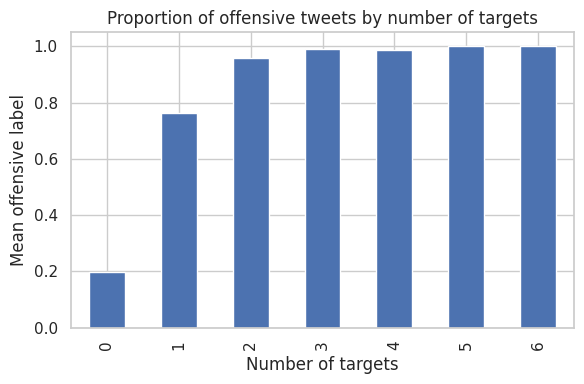

In [59]:
# Graph 5: Offensive proportion by number of targets
offensive_by_targets = data.groupby("num_targets")["label_offensive"].mean()

plt.figure(figsize=(6, 4))
offensive_by_targets.plot(kind="bar")
plt.title("Proportion of offensive tweets by number of targets")
plt.xlabel("Number of targets")
plt.ylabel("Mean offensive label")
plt.tight_layout()
plt.show()

* Preprocessing and feature engineering for modelling

In [60]:
# Basic text cleaning with regular expressions
# lowercase, remove URLs, mentions, hashtags symbols, non-letters, extra spaces
clean_text_series = data_model["text"].str.lower()
clean_text_series = clean_text_series.str.replace(r"http\S+|www\S+|https\S+", " ", regex=True)
clean_text_series = clean_text_series.str.replace(r"@\w+", " ", regex=True)
clean_text_series = clean_text_series.str.replace("#", " ", regex=True)
clean_text_series = clean_text_series.str.replace(r"[^a-z\s]", " ", regex=True)
clean_text_series = clean_text_series.str.replace(r"\s+", " ", regex=True)
clean_text_series = clean_text_series.str.strip()

data_model["clean_text"] = clean_text_series

print("\nCleaned text examples:")
data_model[["text", "clean_text"]].head()


Cleaned text examples:


,text,clean_text
0,@USER Love it keep up the good work sunshine b...,love it keep up the good work sunshine big or ...
1,Lmaooo yâall got other women telling yâall...,lmaooo y all got other women telling y all tha...
2,@USER I feel that sis. They needa begin deacti...,i feel that sis they needa begin deactivating ...
3,"all ""rivalry's"" and shit talking aside im so h...",all rivalry s and shit talking aside im so hap...
4,Black musicians think they have to say a bunch...,black musicians think they have to say a bunch...


In [61]:
# Train–test split
X_text = data_model["clean_text"]
y = data_model["label_offensive"]

In [62]:
# Split Trainin & Testing
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text,y,test_size=0.2,random_state=42,stratify=y)

In [63]:
print("\nTrain size:", X_train_text.shape[0])
print("Test size:", X_test_text.shape[0])


Train size: 3200
Test size: 801


In [64]:
# TF-IDF vectorisation with unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=20000,
    min_df=5,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print("\nTF-IDF feature matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF feature matrix shape (test):", X_test_tfidf.shape)


TF-IDF feature matrix shape (train): (3200, 2152)
TF-IDF feature matrix shape (test): (801, 2152)


* ML model and CNN model – training, testing, evaluation

Model 1

In [26]:
# Machine Learning Model – Multinomial Naive Bayes
nb_model = MultinomialNB()

In [27]:
# Train model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [28]:
# Predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

In [29]:
# Model Evaluation
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("\nAccuracy (Naive Bayes):", nb_accuracy)


Accuracy (Naive Bayes): 0.7253433208489388


In [30]:
print("\nClassification report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=["Not offensive", "Offensive"]))


Classification report (Naive Bayes):
               precision    recall  f1-score   support

Not offensive       0.80      0.02      0.04       223
    Offensive       0.72      1.00      0.84       578

     accuracy                           0.73       801
    macro avg       0.76      0.51      0.44       801
 weighted avg       0.75      0.73      0.62       801



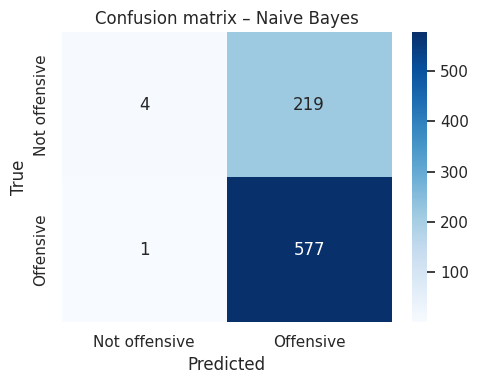

In [31]:
# Confusion Matrix
nb_cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5, 4))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not offensive", "Offensive"], yticklabels=["Not offensive", "Offensive"])
plt.title("Confusion matrix – Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Model 2

In [32]:
# ML model – Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000)

In [33]:
# Train Model
log_reg_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [34]:
# Predictions
y_pred_lr = log_reg_model.predict(X_test_tfidf)

In [35]:
# Model Evaluation
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("\nAccuracy (Logistic Regression):", lr_accuracy)


Accuracy (Logistic Regression): 0.7328339575530587


In [36]:
print("\nClassification report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=["Not offensive", "Offensive"]))


Classification report (Logistic Regression):
               precision    recall  f1-score   support

Not offensive       0.57      0.17      0.26       223
    Offensive       0.75      0.95      0.84       578

     accuracy                           0.73       801
    macro avg       0.66      0.56      0.55       801
 weighted avg       0.70      0.73      0.68       801



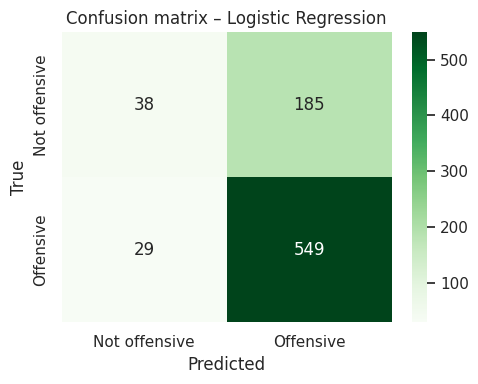

In [37]:
# Confusion Matrix
lr_cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Not offensive", "Offensive"], yticklabels=["Not offensive", "Offensive"])
plt.title("Confusion matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Model 3 - CNN model on token sequences

In [38]:
# Tokenisation and sequence preparation
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

In [39]:
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

In [40]:
max_seq_length = 50
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding="post", truncating="post")

In [41]:
vocab_size = 20000

y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

In [42]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_length))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation="sigmoid"))

In [43]:
cnn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])

In [44]:
print("\nCNN model summary:")
print(cnn_model.summary())


CNN model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
# Train Model
cnn_history = cnn_model.fit(
    X_train_padded,
    y_train_array,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6960 - loss: 0.6307 - val_accuracy: 0.6938 - val_loss: 0.6064
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7274 - loss: 0.5545 - val_accuracy: 0.6938 - val_loss: 0.4987
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.7350 - loss: 0.4289 - val_accuracy: 0.7250 - val_loss: 0.4637
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9030 - loss: 0.3025 - val_accuracy: 0.7469 - val_loss: 0.4629
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9537 - loss: 0.1716 - val_accuracy: 0.7437 - val_loss: 0.5319
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9802 - loss: 0.0840 - val_accuracy: 0.7594 - val_loss: 0.6318
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9881 - loss: 0.0540 - val_accuracy: 0.7437 - val_loss: 0.7625
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9947 - loss: 0.0280 - val_accuracy: 0.7437 

In [46]:
# Prediction
y_pred_cnn_proba = cnn_model.predict(X_test_padded)
y_pred_cnn = (y_pred_cnn_proba.flatten() >= 0.5).astype(int)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [47]:
# Model Evaluation
cnn_accuracy = accuracy_score(y_test_array, y_pred_cnn)
print("\nAccuracy (CNN):", cnn_accuracy)


Accuracy (CNN): 0.7478152309612984


In [48]:
# Classification report
print("\nClassification report (CNN):")
print(classification_report(y_test_array, y_pred_cnn, target_names=["Not offensive", "Offensive"]))


Classification report (CNN):
               precision    recall  f1-score   support

Not offensive       0.56      0.44      0.49       223
    Offensive       0.80      0.87      0.83       578

     accuracy                           0.75       801
    macro avg       0.68      0.65      0.66       801
 weighted avg       0.73      0.75      0.74       801



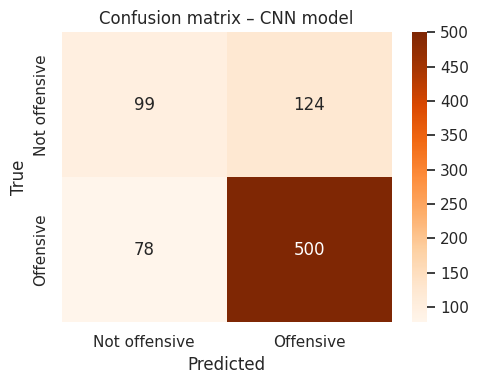

In [49]:
# Confusion Matrix
cnn_cm = confusion_matrix(y_test_array, y_pred_cnn)
plt.figure(figsize=(5, 4))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["Not offensive", "Offensive"], yticklabels=["Not offensive", "Offensive"])
plt.title("Confusion matrix – CNN model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

* Model Comparision

In [50]:
# Collect Report of all models
nb_report = classification_report(y_test, y_pred_nb, output_dict=True, target_names=["Not offensive", "Offensive"])
lr_report = classification_report(y_test, y_pred_lr, output_dict=True, target_names=["Not offensive", "Offensive"])
cnn_report = classification_report(y_test_array, y_pred_cnn, output_dict=True, target_names=["Not offensive", "Offensive"])

In [51]:
metrics_data = []
def extract_metrics(model_name, report):
    return {
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision (Not offensive)": report["Not offensive"]["precision"],
        "Recall (Not offensive)": report["Not offensive"]["recall"],
        "F1-score (Not offensive)": report["Not offensive"]["f1-score"],
        "Precision (Offensive)": report["Offensive"]["precision"],
        "Recall (Offensive)": report["Offensive"]["recall"],
        "F1-score (Offensive)": report["Offensive"]["f1-score"]
    }

metrics_data.append(extract_metrics("Naive Bayes", nb_report))
metrics_data.append(extract_metrics("Logistic Regression", lr_report))
metrics_data.append(extract_metrics("CNN", cnn_report))

metrics_df = pd.DataFrame(metrics_data)
print("\nComparison of Model Metrics:")
metrics_df


Comparison of Model Metrics:


,Model,Accuracy,Precision (Not offensive),Recall (Not offensive),F1-score (Not offensive),Precision (Offensive),Recall (Offensive),F1-score (Offensive)
0,Naive Bayes,0.725343,0.800000,0.017937,0.035088,0.724874,0.998270,0.839884
1,Logistic Regression,0.732834,0.567164,0.170404,0.262069,0.747956,0.949827,0.836890
2,CNN,0.747815,0.559322,0.443946,0.495000,0.801282,0.865052,0.831947


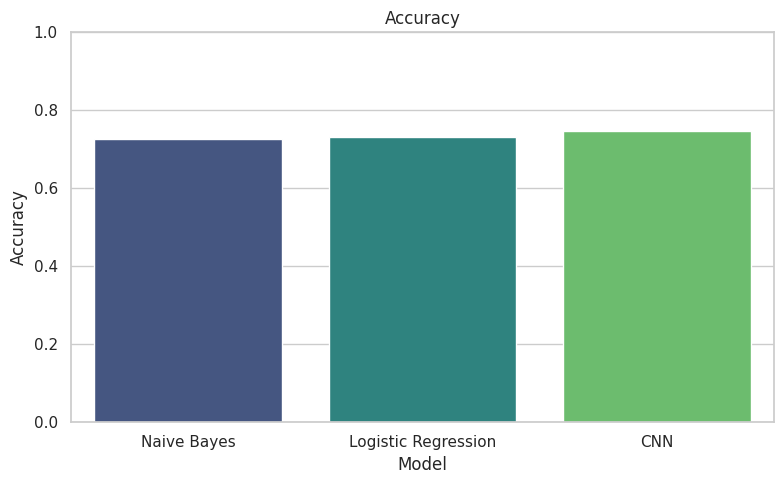

In [52]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=metrics_df, palette="viridis")
plt.title("Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()